In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


Importation des bibliothèques


In [4]:

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from scipy.special import boxcox1p
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#**EDA : Exploratory Data Analysis**

>Exploratory Data Analysis (EDA) plays a crucial role in this project, as it allows us to understand the underlying patterns, relationships, and potential anomalies within the dataset. By visually examining variables like 'SalePrice' and their distributions, as well as exploring correlations between features, EDA helps identify key drivers of house prices and informs decisions for feature selection and model development. This step also aids in detecting outliers, missing values, and skewed distributions, which may require transformations or other preprocessing techniques. In a project like this, where predicting housing prices is the goal, thorough EDA ensures that we approach the data in an informed manner, maximizing the accuracy and interpretability of the predictive models.

In [11]:
#Charger les données
train_df =pd.read_csv('/content/drive/MyDrive/train.csv')
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [12]:
test_df =pd.read_csv('/content/drive/MyDrive/test.csv')
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


#Data Description

In [13]:
train_df.shape

(1460, 81)

In [14]:
test_df.shape

(1459, 80)

In [15]:
#Display all column names in the training dataset
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

#Summary Statistics of the Dataset:

In [16]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [17]:
#Select and display only the "numerical columns" in the training dataset
train_df.dtypes[train_df.dtypes != 'object']

,0
Id,int64
MSSubClass,int64
LotFrontage,float64
LotArea,int64
OverallQual,int64
OverallCond,int64
YearBuilt,int64
YearRemodAdd,int64
MasVnrArea,float64
BsmtFinSF1,int64


#**Feature vs. Price Patterns & Outlier Exploration**

>In this step of the Exploratory Data Analysis (EDA), we investigate the relationships between individual features and house sale prices using scatter plots. This visual inspection helps detect non-linear patterns, strong correlations, or saturation effects in variables such as living area, number of rooms, quality ratings, and more.

>Alongside visualization, we perform a targeted outlier analysis using logical conditions to flag anomalous records (e.g., unusually large basements, extreme bathroom counts, or old homes with unexpectedly high prices). These rows are not immediately removed but are highlighted for further investigation since they can bias regression models, inflate errors, or skew learning algorithms if left unchecked.

>This dual analysis supports the overall goal of building a robust house price prediction model, by ensuring the training data is both clean and reflective of general housing market behavior. It also provides early hints about important predictors that might strongly influence pricing, guiding the next steps in feature engineering and model selection.

##Bivariate Analysis of Numerical Features in the Training Dataset

>In this step, we performed a detailed analysis to identify and display the numerical columns present in the training dataset. By isolating these columns, we are able to focus on the variables that contain continuous or discrete numerical data, which are typically more relevant for various statistical and machine learning analyses. This step allows us to better understand the data structure and prepare for further operations such as exploratory data analysis (EDA), feature engineering, or modeling. Identifying these numerical columns is essential for the next stages of the project, where we can analyze the relationships between variables and detect patterns or outliers that may influence the performance of predictive models.

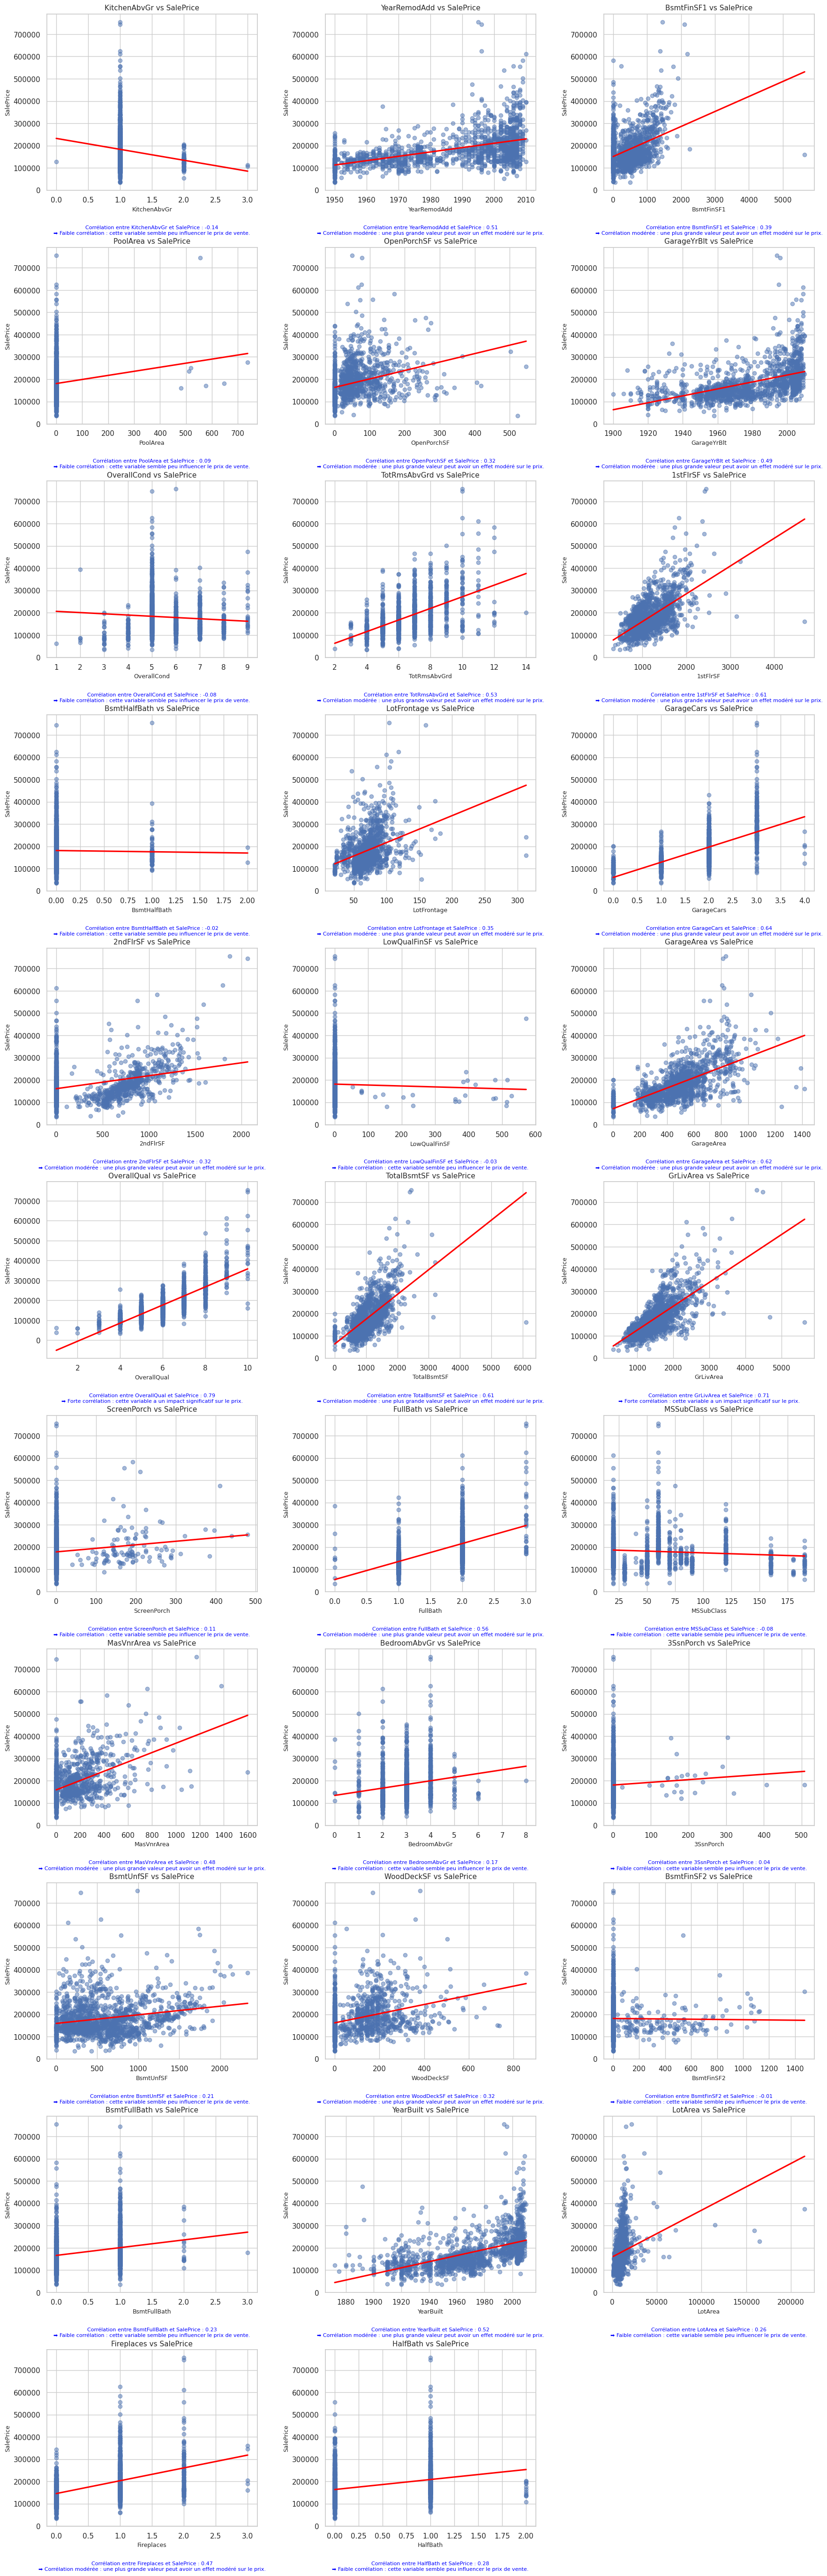

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

features_to_plot = list(set([
    'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
    'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
    'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
    'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
    'GarageYrBlt', 'GarageCars', 'GarageArea', 'PoolArea', 'ScreenPorch',
    '3SsnPorch', 'OpenPorchSF', 'WoodDeckSF'
]))

sns.set(style="whitegrid")
cols = 3
rows = -(-len(features_to_plot) // cols)  # ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 5))
axes = axes.flatten()

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx]

    if feature in train_df.columns:
        sns.regplot(
            x=feature,
            y='SalePrice',
            data=train_df,
            ax=ax,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red'},
            ci=None
        )
        ax.set_title(f"{feature} vs SalePrice", fontsize=11)
        ax.set_xlabel(feature, fontsize=9)
        ax.set_ylabel("SalePrice", fontsize=9)

        corr = train_df[feature].corr(train_df['SalePrice'])
        ax.text(0.5, -0.25,
                f"Corrélation entre {feature} et SalePrice : {corr:.2f}\n" +
                ("➡️ Faible corrélation : cette variable semble peu influencer le prix de vente." if abs(corr) < 0.3 else
                 "➡️ Corrélation modérée : une plus grande valeur peut avoir un effet modéré sur le prix." if abs(corr) < 0.7 else
                 "➡️ Forte corrélation : cette variable a un impact significatif sur le prix."),
                transform=ax.transAxes,
                fontsize=8,
                color='blue',
                ha='center')
    else:
        ax.axis('off')
        ax.text(0.5, 0.5, f"{feature}\nn'existe pas",
                transform=ax.transAxes,
                ha='center', va='center', fontsize=10, color='red')

# Hide any unused axes
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()



Variable cible

In [ ]:
train['SalePrice'].describe()

In [ ]:

plt.figure(figsize=(10, 2))
sns.boxplot(x=train['SalePrice'])
plt.title('Boxplot  SalePrice')
plt.show()


On remarque qu'il y a 2 outliers  avec des prix supérieurs à 70 000

In [ ]:
sns.distplot(train['SalePrice'])

cette courbe est asymetrique à droite (positive skew)  
* Majorité des maisons ont un prix autour de 100,000 à 200,000 $. ( Mean= 180921.19 $)
* Présence d’outliers :
Les valeurs très élevées (> 500,000) sont rares mais influentes.

Correlation de chaque  variable avec la variable cible

In [ ]:
# Calcul de la corrélation entre SalePrice et les autres variables numériques
correlation_matrix = train.corr(numeric_only=True)

# Trie des variables les plus corrélées avec SalePrice (hors elle-même)
correlated_features = correlation_matrix['SalePrice'].sort_values(ascending=False)[1:]

# Affichage des  variables les plus corrélées
print("Les variables les plus corrélées avec SalePrice :")
print(correlated_features)


plt.figure(figsize=(10, 6))
sns.barplot(x=correlated_features.values, y=correlated_features.index, palette="coolwarm")
plt.title("Corrélation avec SalePrice")
plt.xlabel("Coefficient de corrélation")
plt.ylabel("Variables")
plt.show()

Afin de rendre SalePrice plus normal, nous utilisons la transformation logarithmique log1p.

* Réduire l'influence des outliers (prix très élevés),

* Rendre la distribution plus symétrique,

* Améliorer la performance des modèles.

In [ ]:

y = np.log1p(train['SalePrice'])

In [ ]:
sns.distplot(y)
plt.title("density of SalePrice after Log transformation")

Les Valeurs Manquantes

In [ ]:
train.isnull().sum()


Les valeurs manquantes en Pourcentages


In [ ]:
# Pourcentage de valeurs nulles par colonne
null_percent = train.isnull().mean() * 100

# Colonnes avec plus de 60% de valeurs nulles
cols_above  = null_percent[null_percent >=10]

# Affichage
print(cols_above )

In [ ]:

# Bar plot
cols_above.sort_values().plot(kind='barh')
plt.xlabel("Pourcentage de valeurs nulles")
plt.title("Colonnes avec > 10% de valeurs nulles")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Suppression des Variables inutile pour le modèle  :
* Supprimer 'Id' et 'SalePrice' pour le train dataset
* Supprimer 'Id' pour le test dataset

In [ ]:
train.drop(['Id', 'SalePrice'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

Fusionner les ensembles de données d'entraînement et de test pour un traitement global et cohérent.

In [ ]:
all_data = pd.concat([train, test], axis=0).reset_index(drop=True)


**Pour les Colonnes Catgorielles** : Remplacer  les valeurs manquantes (NaN) par la chaîne de caractères 'None'

In [ ]:
for col in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']:
    all_data[col] = all_data[col].fillna('None')



 **Pour les colonnes numérique** : Remplacer les valeurs manquantes par 0

In [ ]:
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
            'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']:
    all_data[col] = all_data[col].fillna(0)

Remplit les valeurs manquantes de LotFrontage avec la médiane du quartier (Neighborhood) correspondant, ce qui permet une imputation plus cohérente et contextuelle.
*  On respecte mieux la distribution des données, ce qui peut améliorer les performances du modèle.

In [ ]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))


**Feature Engineering**

In [ ]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['TotalBathrooms'] = (all_data['FullBath'] + 0.5 * all_data['HalfBath'] +
                               all_data['BsmtFullBath'] + 0.5 * all_data['BsmtHalfBath'])
all_data['IsRemodeled'] = (all_data['YearBuilt'] != all_data['YearRemodAdd']).astype(int)
all_data['Age'] = all_data['YrSold'] - all_data['YearBuilt']


Correction Skew

On récupère toutes les colonnes numériques du jeu de données all_data.



In [ ]:

numeric_feats = all_data.select_dtypes(include=['number']).columns


 Pour chaque variable numérique, on applique la fonction skew() (asymétrie). On enlève les NaN avec .dropna().

In [ ]:
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))


On garde seulement les colonnes dont le skew est supérieur à 0.75 (seuil typique pour détecter une asymétrie significative).

In [ ]:
skewed_feats = skewed_feats[skewed_feats > 0.75].index


on applique une transformation Box-Cox modifiée : boxcox1p(x, λ)
avec lambda hyperparametre qui controle l'intensité de la transformation

In [ ]:
for feat in skewed_feats:
  all_data[feat] = boxcox1p(all_data[feat], 0.15)


#  One-hot encoding


applique  la transformation One-Hot Encoding à toutes les colonnes catégorielles de all_data.



In [ ]:
all_data = pd.get_dummies(all_data)


# Séparation du train et test

In [ ]:
X = all_data[:len(train)]
X_test = all_data[len(train):]

# Normalisation robuste

Contrairement à StandardScaler (qui utilise la moyenne et l’écart-type), RobustScaler se base sur :

* La médiane (au lieu de la moyenne)

* L’écart interquartile (IQR) : c’est-à-dire Q3 - Q1

* X_scaled = (X - median) / IQR
* Robuste face aux outliers

In [ ]:

scaler = RobustScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

# Cross Validation


* mesurer les performances du modèle en le testant sur n_splits (5):
➜ à chaque itération, 4 folds sont utilisés pour entraîner, 1 pour tester

* shuffle=True : Mélange les données avant de les diviser
➜ évite que les données soient triées (par date, prix, etc.)

* random_state=42 : Assure que le mélange est reproductible
➜  toujours les mêmes splits



In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)


Cette fonction retourne la RMSE moyenne en validation croisée, pour évaluer la précision d’un modèle de régression.

In [ ]:
def rmse_cv(model):
    return np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))


# Modeles

Le stacking est une technique d'ensemble avancée qui combine plusieurs modèles  pour améliorer les performances globales.

J'ai utilisé 2 modeles lineaires  (Lasso et Ridge )
et 3 modèles de boosting : (Xgboost , lightgbm , catboosting)
 Cette méthode :
* Combine les forces de plusieurs modèles

* Réduit le biais et la variance

* Très utile quand les modèles de base sont complémentaires



In [ ]:

ridge = Ridge(alpha=10)
lasso = Lasso(alpha=0.0005)
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=3, subsample=0.7, colsample_bytree=0.7, random_state=42)
lgb = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=32, random_state=42)
cat = CatBoostRegressor(verbose=0, iterations=1000, learning_rate=0.05, depth=6, random_state=42)


# Stacking

On crée un modèle d’ensemble (stacking) avec Ridge, Lasso, XGBoost, LightGBM, et CatBoost comme base learners, et un Lasso final qui combine leurs prédictions et les features originales pour améliorer les performances.

In [ ]:

stack = StackingRegressor(
    estimators=[('ridge', ridge), ('lasso', lasso), ('xgb', xgb), ('lgb', lgb), ('cat', cat)],
    final_estimator=Lasso(alpha=0.0005),
    passthrough=True
)

# Score

Cette boucle affiche les performances (RMSE moyenne ± écart-type) de plusieurs modèles de régression évalués par validation croisée.

In [ ]:
for model, name in zip([ridge, lasso, xgb, lgb, cat, stack], ['Ridge', 'Lasso', 'XGB', 'LGBM', 'CatBoost', 'Stacking']):
    score = rmse_cv(model)
    print(f'{name} CV RMSE: {score.mean():.5f} ± {score.std():.5f}')


# Fit final et Prédiction

 C’est l’entraînement final du modèle, après toutes les validations croisées.

In [ ]:

stack.fit(X, y)


* Prédit les prix sur les données de test avec le modèle entraîné :

* stack.predict(X_test) donne la prédiction log-transformée .

* np.expm1() inverse la transformation logarithmique, donc :

* SalePrice pr
e
ˊ
dite
=
exp
⁡
(
log(SalePrice)
)
−
1
SalePrice pr
e
ˊ
 dite=exp(log(SalePrice))−1
*  Ce qui reconvertit les prédictions dans l’échelle réelle des prix .

In [ ]:
final_preds = np.expm1(stack.predict(X_test))




# Soumission

In [ ]:
# Soumission

submission = pd.DataFrame({
    'Id': test_ID,
    'SalePrice': final_preds
})
submission.to_csv('submission_stack.csv', index=False)
